In [1]:
import numpy as np
import pandas as pd
import emcee        # MCMC Sampler
import matplotlib.pyplot as plt
import glob
import corner       # Corner plot

%matplotlib inline
# Options for pandas dataframe (if required).
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

First, we need to locate and import all the files we wish to model. We can select the data for each file and add to a dataframe.

_**NOTE**: Directory below will need to be changed if this is downloaded and run from another computer._

['/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman30+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman75+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman35+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman80+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman95+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman50+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman65+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman40+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman85+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman45+.csv', '/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/zeeman70+.csv'

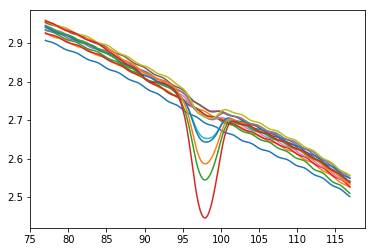

In [2]:
files = glob.glob('/home/daniel/Documents/hirosplacement/Data/temperature_scan/180725cooling/*+.csv')
print(files)
for f1 in sorted(files):
    data = pd.read_csv(f1, sep=';')
    plt.plot(data['Piezo Voltage (V)'], data['Fine In 1 (V)'])
    
temp = [int(n.split('+'[0])[0][-2:]) for n in sorted(files)]

Using the imported data, we can also plot all the separate normalised traces onto a single plot.

In [3]:
dfs = [pd.read_csv(n,sep=';') for n in sorted(files)]
data = np.zeros([len(dfs), len(dfs[0])])
for idx, df in enumerate(dfs):
    data[idx, :] = df['Fine In 1 (V)'].values
    
n = np.linspace(0,1,len(dfs[0]))
for idx in range(1, len(dfs)):
    data[idx, :] *= (data[0, 200] / data[idx, 200])

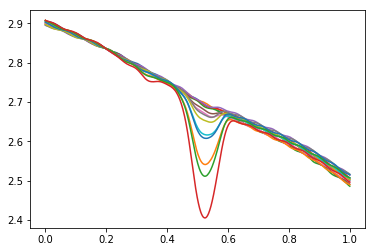

In [4]:
fig, ax = plt.subplots()
for i in range(len(dfs)):
    ax.plot(n, data[i, :])
    


Next, we can define a polynomial function using poly1d. This considers polynomials of the form $a_{3}x^{3}+a_{2}x^{2}+a_{1}+a_{0}$, and we also subtract a Gaussian Function with three parameters: nu (centre); w (FWHM of Gaussian); d (depth). This gives a shape that roughly reflects the data, that we can then use for a rough manual fitting to the data.

The second function exists to produce the model predictions for the mcmc solver, and replaces the parameter *d* with two new parameters *dm* and *dc*. The most simplistic model would be a linear one, of the form $y=dm\cdot x + dc$, however this does not accurately reflect the effect of temperature change on the line-depth. Hence, we improve this by using a power-law relationship of the form $y=dc\cdot x^{2dm}$

In [5]:
def func(n, p):
    a3, a2, a1, a0, nu, w, d = p #* unpacks
    cont = np.poly1d([a3, a2, a1, a0])(n) # Creates 1d polynomial
    cont -= d*np.exp((-0.5*(n-nu)**2) / w**2)
    return cont

def gunc(n, q, temp):
    ncomp = len(temp)
    models = np.zeros([ncomp, len(n)])
    a3, a2, a1, a0, nu, w, dc, dm = q
    for comp in range(ncomp):
        #d = temp[comp] * dm + dc
        d = dc *((temp[comp]**2)**dm) / 1e6    # Division by 1e6 removes large numbers from calculations
        cont = np.poly1d([a3, a2, a1, a0])(n)
        models[comp, :] = cont - d * np.exp(-0.5*(n-nu)**2 / w**2)
    return models

We can also plot a single datafile (the wavy line in the figure below) against the predictions provided as a result of varying the temperature in our function **gunc** above.

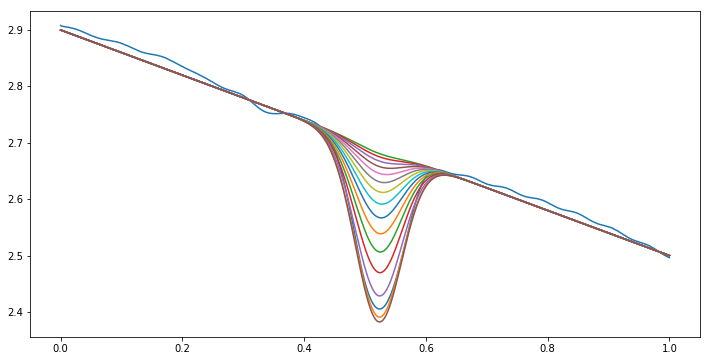

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(n, data[-1, :])
ax.plot(n, func(n, [0, 0, -0.4, 2.9, 0.522, 0.038, 0.3]))
for idx in range(len(temp)):
    #ax.plot(n, gunc(n, [0, 0, -0.4, 2.9, 0.522, 0.038, -0.05, 0.0036], temp)[idx,:])
    ax.plot(n, gunc(n, [0, 0, -0.4, 2.9, 0.522, 0.038, 0.36, 1.5], temp)[idx,:])
    #ax.plot(n, gunc(n, [0, 0, -0.4, 2.9, 0.522, 0.038, 0.008, 0.2], temp)[idx,:])

Here we define a number of new functions:
* **lnlike** - a likliness function, similar to a Chi-squared distribution.
* **lnprior** - this function acts to prevent the solver processing numbers that would otherwise result in breakages in the run (for example numbers becoming too large during calculation).
* **lnprob** - the full log-probability distribution given by combining the previous two functions

In [7]:
def lnlike(q, n, y, yerr, temp):
    model = gunc(n, q, temp)
    return -0.5 * (np.sum((y-model)**2 / yerr**2))

In [8]:
def lnprior(q):
    a3, a2, a1, a0, nu, w, dc, dm = q
    if dm < 10:
        return 0.0
    return -np.inf

In [9]:
def lnprob(q, n, y, yerr, temp):
    lp = lnprior(q)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(q, n, y, yerr, temp)

Below, **start** represents our initial estimate values based on the manual tuning above.

We also define a number of dimensions (given by number of free parameters), and a number of 'walkers', which start at randomised positions based around these initial values. The plot below shows these random starting positions for a particular set.

Walker Analogy:
_Imagine you have a very large amount of cartographers at your disposal, who are randomly placed somewhere in the Lake District and are told to start walking. You give them the following rules: if you walk uphill, continue; if you walk downhill, turn around then continue. The result is that the cartographers will 'seek' out the highest points in their locality -- the overall effect of this is that you produce a map of the topology of the area._

In [10]:
#start = [0, 0, -0.4, 2.95, 0.52, 0.3, 0.038]
start = [0, 0, -0.4, 2.9, 0.522, 0.038, 0.36, 1.5]
#start2 = [0, 0, -0.4, 2.95, 0.52, 0.12, 0.038]

ndim, nwalkers = len(start), 100
pos = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#pos2 = [start2 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

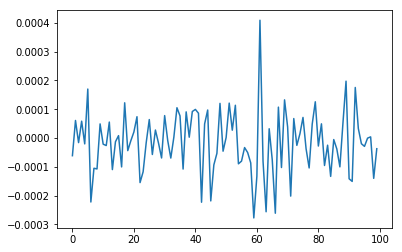

In [11]:
fig, ax = plt.subplots()
ax.plot([n[0] for n in pos]) # Shows random start positions for walkers

The use of the index **-1** pulls the last value in an array.

At this point we are able to define the sampler that we will use and define how long we desire it to run for.

In [12]:
y = data
yerr = np.sqrt(y)/50
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n, y, yerr, temp))

In [13]:
sampler.run_mcmc(pos, 3000)

(array([[-4.51131703e-02,  4.15465938e-02, -3.97297720e-01,
          2.90846031e+00,  5.22631689e-01,  3.86756889e-02,
          7.02055012e-05,  2.42874141e+00],
        [-2.47567412e-02,  1.28494413e-02, -3.86396427e-01,
          2.90768780e+00,  5.22241424e-01,  3.90174999e-02,
          1.49034795e-04,  2.34184255e+00],
        [-1.49065785e-02, -6.20626594e-04, -3.82822894e-01,
          2.90760384e+00,  5.22437807e-01,  3.85232230e-02,
          5.98055453e-05,  2.44590215e+00],
        [-1.88353063e-02,  2.36499559e-03, -3.80331721e-01,
          2.90629573e+00,  5.23300302e-01,  3.85784534e-02,
          1.08635624e-04,  2.37812405e+00],
        [-2.53797095e-02,  2.38211735e-02, -3.96478608e-01,
          2.90829424e+00,  5.22062083e-01,  3.80160667e-02,
          7.36501109e-05,  2.42264184e+00],
        [-3.76538622e-02,  3.68752301e-02, -3.99564913e-01,
          2.90928358e+00,  5.22329601e-01,  3.86338448e-02,
          3.33880192e-04,  2.25369426e+00],
        [-2.2575

The middle argument in the brackets below represent the 'burn' value.

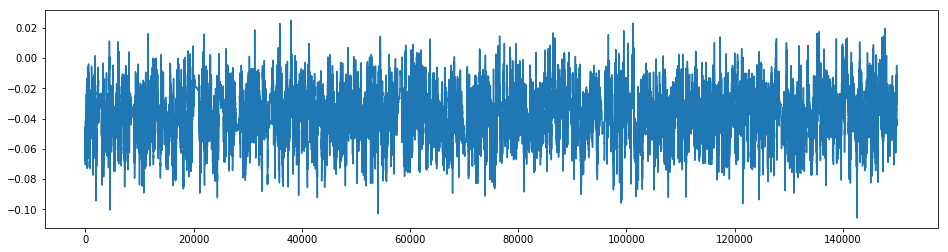

In [14]:
samples = sampler.chain[:, 1500:, :].reshape((-1, ndim))
#samples2 = sampler2.chain[:, 150:, :].reshape((-1, ndim))
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(samples[:,0])
#ax.plot(samples2[:,0])

The corner plot below shows the correlation between different sets of values

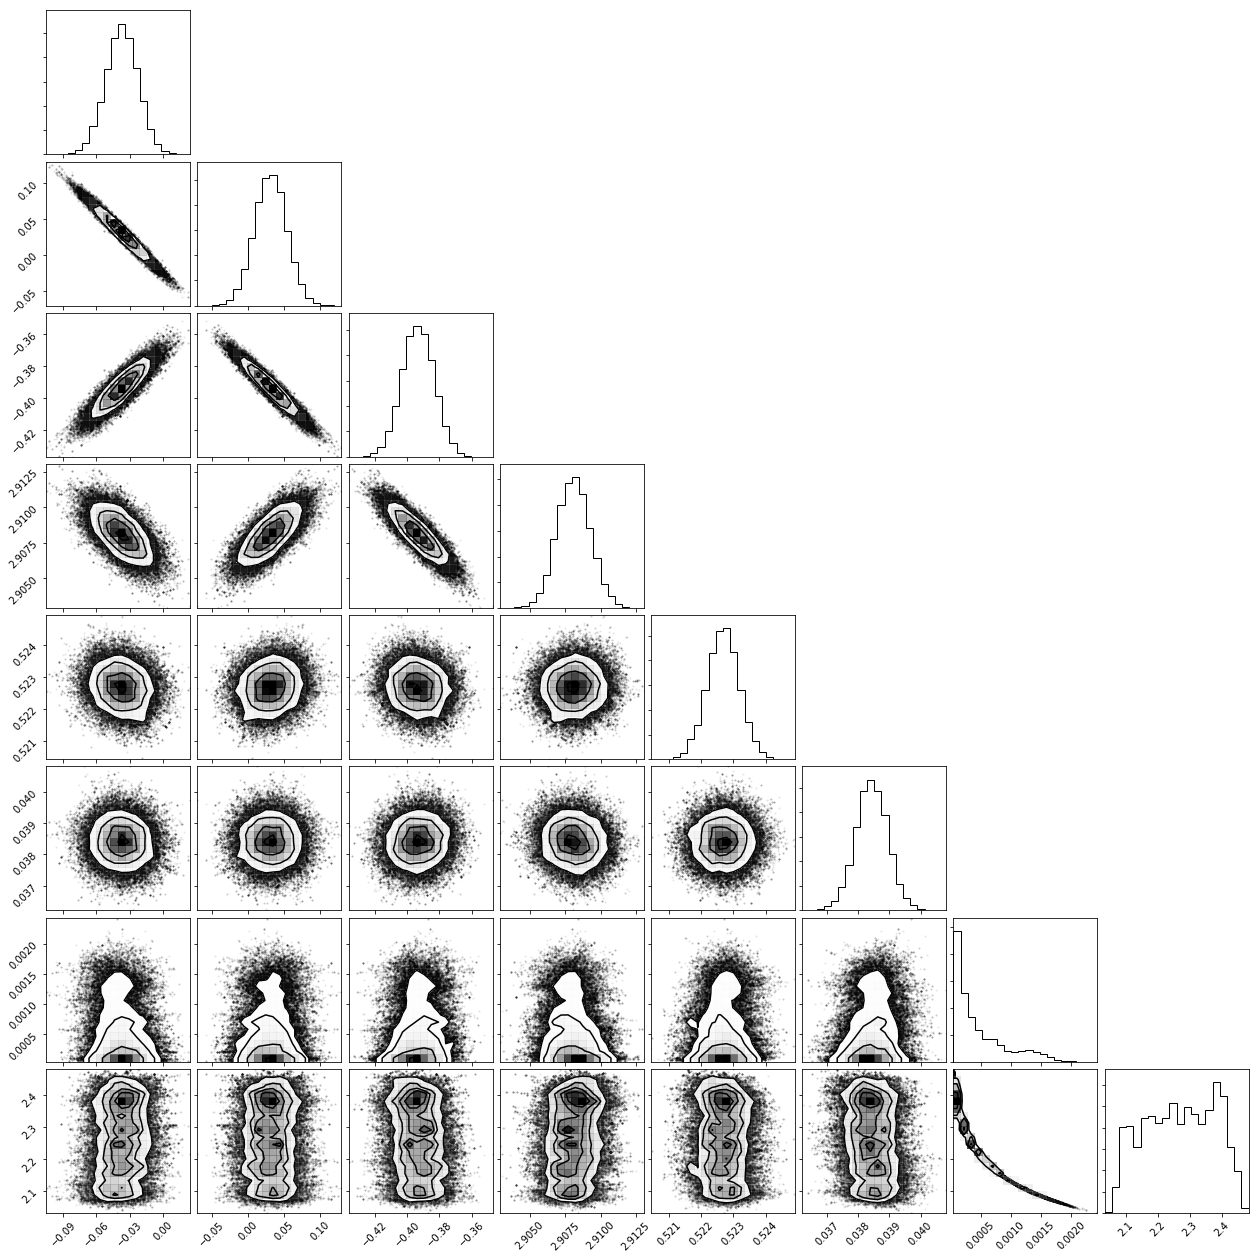

In [15]:
fig = corner.corner(samples)
#fig = corner.corner(samples2)

Text(0,0.5,'Intensity $(V)$')

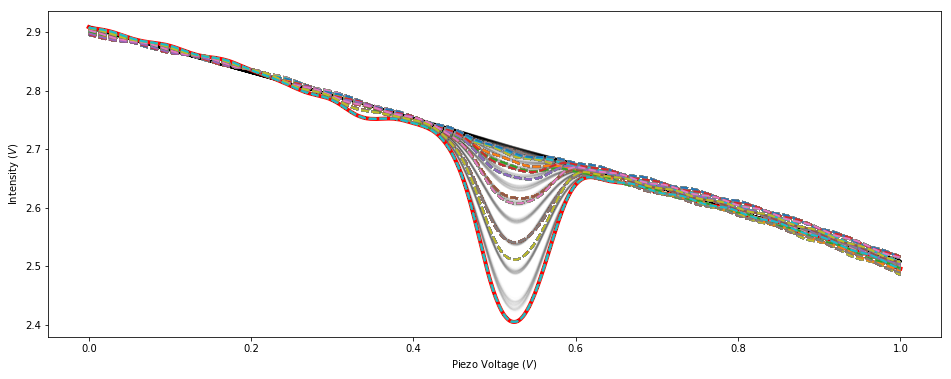

In [17]:
fig, ax = plt.subplots(figsize=(16,6))
    
#fig.savefig('mcmc_test.pdf')
ax.plot(n, data[-1, :], 'r-', zorder=5, lw=4)
for i in range(0, len(samples[:,0]), 2000):
    for nc in range(len(temp)):
        ax.plot(n, data[nc, :], zorder=5, lw=2, linestyle='--')
        ax.plot(n, gunc(n, samples[i, :], temp)[nc,:], alpha=0.01, c='k')
    
    
ax.set_xlabel('Piezo Voltage $(V)$')
ax.set_ylabel('Intensity $(V)$')